<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/CNN_Proj1_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tasks:
1.   import the CIFAR10 datset
2.   create 3 partitions from the dataset (train/dev/test), making sure the data are 3x32x32
3.   apply some transformation(s)
4.   build a CNN model to categorize each iamge into a cetegory
5.   plot loss and accuracy vs. epochs for each partitio (train/dev/test)

In [53]:
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [54]:
# use GPU if available：
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [55]:
device

device(type='cuda', index=0)

In [56]:
# transformations:
transform = T.Compose([ T.ToTensor(), # convert to tensor
                        # torchvision.transforms.Normalize(mean, std, inplace=False)
                        # the first [.5,.5,.5] represents the mean values for each channel (R, G, B)
                        # the second [.5,.5,.5] represents the standard deviation values for each channel (R, G, B)
                        T.Normalize([.5,.5,.5],[.5,.5,.5]) # normalizes pixel values from [0, 255] to [-1,1] by subtracting 0.5 from each pixel value and then dividing by 0.5
                       ])

# import the CIFAR10 dataset & simultaneously apply the transformations:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform) # `train=True` -> trainset
# print(type(trainset)) # `torchvision.datasets.cifar.CIFAR10` object
print("trainset:", trainset.data.shape) # (50000, 32, 32, 3)
# print(trainset.classes) # list categories -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # `train=False` -> devtest
print("dev+test set:", devtest.data.shape) # (10000, 32, 32, 3)

# a random permutation of indices:
randidx = np.random.permutation(10000)
# print(randidx) # eg: [9546 6633 4797 ... 1222 7671 8219]
# print(len(randidx)) # 10000

# split the devtest into devset and testset:
devset  = Subset(devtest,randidx[:6000])
print(type(devset)) # 'torch.utils.data.dataset.Subset' object
print(len(devset)) # 6000
testset = Subset(devtest,randidx[6000:])
print(len(testset)) # 4000

# convert to DataLoaders:
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize)    # mini-batches for dev
test_loader  = DataLoader(testset, batch_size=len(testset)) # no mini-batch for test

Files already downloaded and verified
trainset: (50000, 32, 32, 3)
Files already downloaded and verified
dev+test set: (10000, 32, 32, 3)
<class 'torch.utils.data.dataset.Subset'>
6000
4000


👆 Split data

train: 50000 32x32 RGB images in 10 classes (5000 images per class)

  dev:  6000

 test:  4000

In [57]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# check the range of pixel intensity values
print('Data value range:')
print( (np.min(trainset.data),np.max(trainset.data)) ) # before the normalization is actually applied to the images
# normalization is only applied when the images are converted to tensors using `T.ToTensor()` in the `transform` list

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
50000
6000
4000
Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [58]:
# Pixel values are not normalized???

# wait...
X,y = next(iter(train_loader)) # batchsize = 32
print( X.data.shape ) # [32, 3, 32, 32]
print( y.data.shape ) # [32]

# pixel intensity range
print('\nTrain data value range:')
print( (torch.min(X.data),torch.max(X.data)) )

torch.Size([32, 3, 32, 32])
torch.Size([32])

Train data value range:
(tensor(-1.), tensor(1.))


👆 Interpretation:
- The transformations are actually not applied to the images directly.
- Instead, the transformations are ***stored*** and they are applied to the images only when we ***export the data*** or when we ***pull a little batch*** of data out of these data loaders.

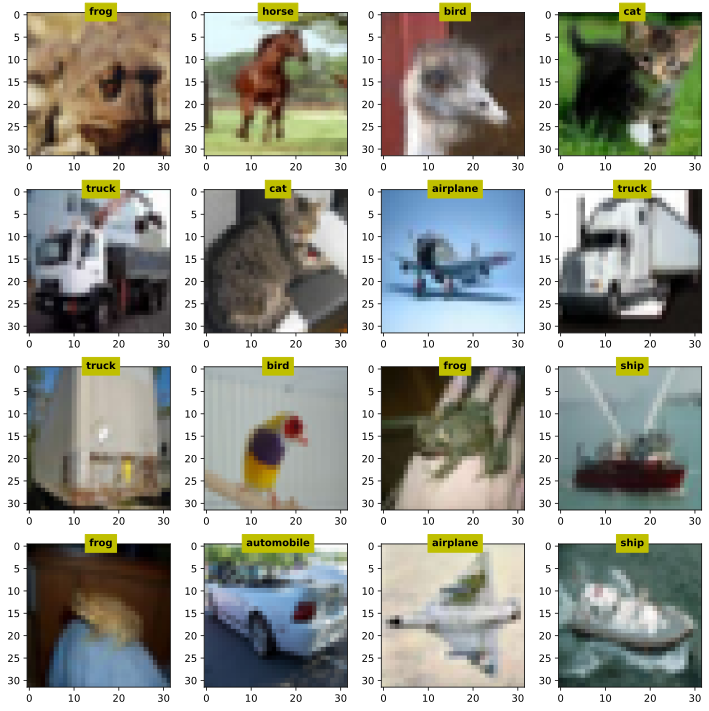

In [65]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image & transpose back to 32x32x3
  pic = X.data[i].numpy().transpose((1,2,0)) # (3, 32, 32) -> (32, 32, 3)
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # visualize
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  # ax.axis('off')

plt.tight_layout()
plt.show()

In [60]:
# build a class for the model & create an instance:
def makeTheNet(printtoggle=False): # introduce variable

  # build a class for the model
  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.print = printtoggle

      # -------------- feature map layers --------------

      # 1st convolution layer
      self.conv1  = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # 2nd convolution layer
      self.conv2  = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # 3rd convolution layer
      self.conv3  = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      # -------------- linear decision layers --------------

      self.fc1 = nn.Linear(2*2*256,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,10) # 10 categories


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # 1st block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPBR block: {list(x.shape)}')

      # 2nd block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPBR block: {list(x.shape)}')

      # 3rd block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPBR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0] # calc reshape size
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training) # added 50% dropout rate
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training: traning=False, training turned off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x


  # create a model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss() # for categorical data

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [62]:
# test the model with one batch:

net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader)) # extract a batch
yHat = net(X) # output
print("\noutput size:", yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print('\nloss:', loss)

Input: [32, 3, 32, 32]
First CPBR block: [32, 64, 16, 16]
Second CPR block: [32, 128, 7, 7]
Third CPR block: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]

output size: torch.Size([32, 10])

loss: tensor(2.2963, grad_fn=<NllLossBackward0>)


# Create a function to train the model:

In [63]:
# a function to train the model:

def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # number of epochs
  numepochs = 10

  # send the model instance to GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    net.train() # switch to train mode, which means we switch on batch normalization and dropouts
    batchAcc  = []

    # loop over training batches
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy for this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # record losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test performance (in batches)
    net.eval() # switch to evaluation/test mode, which means we switch off batch normalization and dropouts
    batchAcc  = []
    batchLoss = []

    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

# Train the model & show the results:

In [64]:
# ~2 minutes with 10 epochs on GPU
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

In [66]:
# test set now:

net.eval() # switch to test mode
X,y = next(iter(test_loader)) # extract batch data from the test_loader

# push batch data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

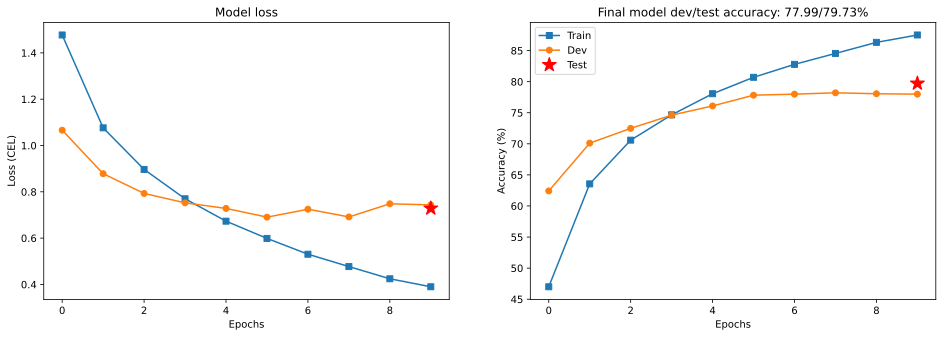

In [67]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()